Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         Date    Open    High     Low   Close   Volume  OpenInt
0  1970-01-02  1.4972  1.4972  1.4893  1.4972  1459617        0
1  1970-01-05  1.4972  1.5297  1.4972  1.5297  2338570        0
2  1970-01-06  1.5297  1.5297  1.5055  1.5216  1531212        0
3  1970-01-07  1.5216  1.5216  1.5138  1.5138  1141448        0
4  1970-01-08  1.5138  1.5297  1.5055  1.5138  1336326        0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


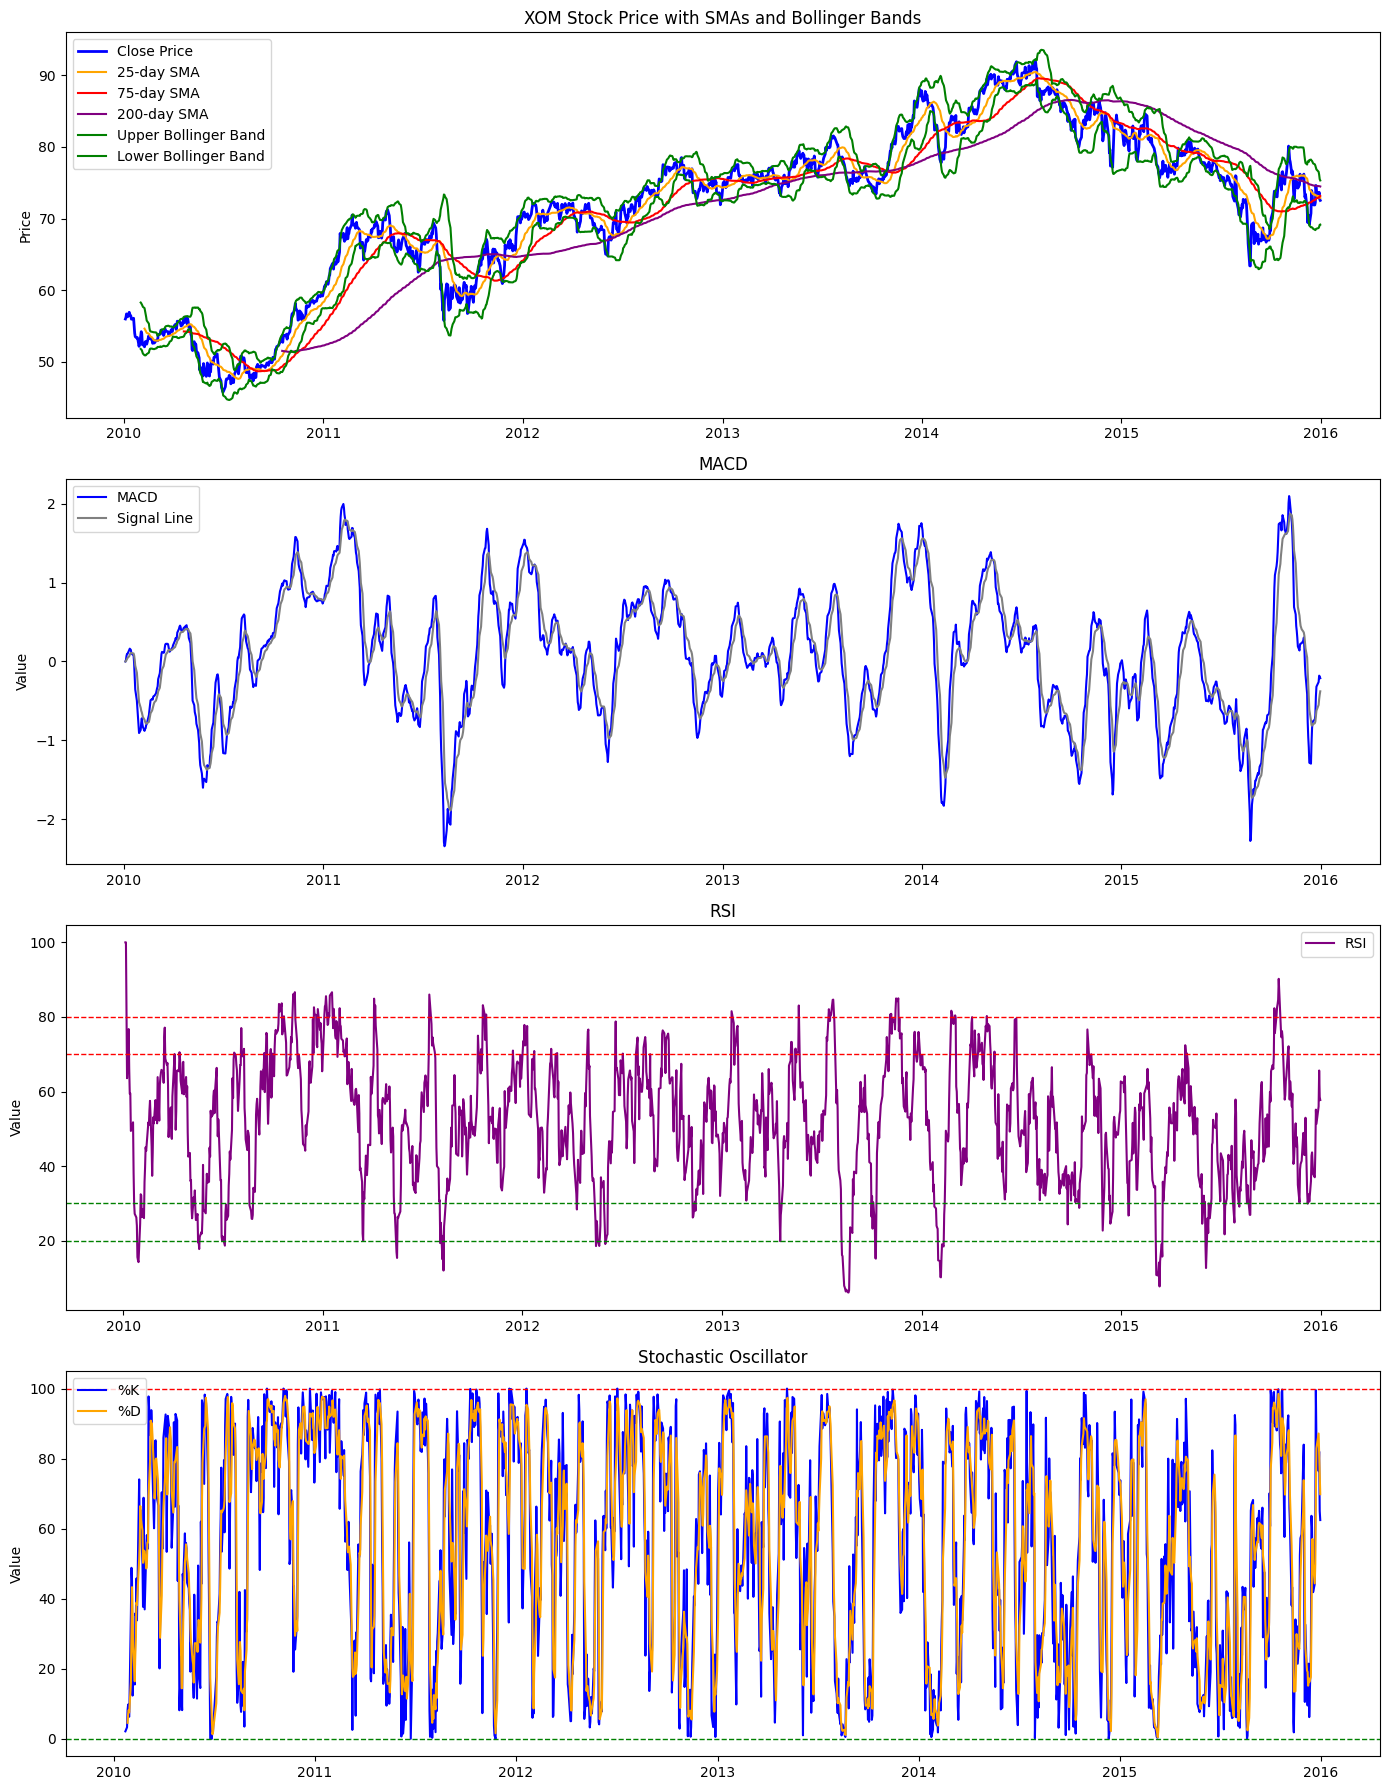

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Google Driveをマウントする
drive.mount('/content/drive')

# CSVファイルを読み込む
file_path = '/content/xom.us.csv'  # ファイルパスを適切に設定する
data = pd.read_csv(file_path)

# 日付をdatetime型に変換する
data['Date'] = pd.to_datetime(data['Date'])

# 指定された期間のデータを抽出する
start_date = '2010-01-01'
end_date = '2015-12-31'
filtered_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()

# Simple Moving Averages (SMA)
filtered_data['SMA25'] = filtered_data['Close'].rolling(window=25).mean()
filtered_data['SMA75'] = filtered_data['Close'].rolling(window=75).mean()
filtered_data['SMA200'] = filtered_data['Close'].rolling(window=200).mean()

# MACD
filtered_data['EMA12'] = filtered_data['Close'].ewm(span=12, adjust=False).mean()
filtered_data['EMA26'] = filtered_data['Close'].ewm(span=26, adjust=False).mean()
filtered_data['MACD'] = filtered_data['EMA12'] - filtered_data['EMA26']
filtered_data['Signal'] = filtered_data['MACD'].ewm(span=9, adjust=False).mean()

# RSI
def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

filtered_data['RSI'] = calculate_rsi(filtered_data, 14)

# ストキャスティクス (Stochastic Oscillator)
def calculate_stochastic_oscillator(data, k_window, d_window):
    low_min = data['Low'].rolling(window=k_window).min()
    high_max = data['High'].rolling(window=k_window).max()

    data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    data['%D'] = data['%K'].rolling(window=d_window).mean()

    return data

filtered_data = calculate_stochastic_oscillator(filtered_data, 14, 3)

# ボリンジャーバンドの計算
window_size = 20
rolling_mean = filtered_data['Close'].rolling(window=window_size).mean()
rolling_std = filtered_data['Close'].rolling(window=window_size).std()

# ボリンジャーバンドの上限と下限を計算する
filtered_data['UpperBand'] = rolling_mean + 2 * rolling_std
filtered_data['LowerBand'] = rolling_mean - 2 * rolling_std

# グラフを作成
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 18))

# 株価とSMAのチャート
ax1.plot(filtered_data['Date'], filtered_data['Close'], label='Close Price', color='b', linewidth=2)
ax1.plot(filtered_data['Date'], filtered_data['SMA25'], label='25-day SMA', color='orange')
ax1.plot(filtered_data['Date'], filtered_data['SMA75'], label='75-day SMA', color='red')
ax1.plot(filtered_data['Date'], filtered_data['SMA200'], label='200-day SMA', color='purple')
ax1.plot(filtered_data['Date'], filtered_data['UpperBand'], linestyle='-', color='green', label='Upper Bollinger Band')
ax1.plot(filtered_data['Date'], filtered_data['LowerBand'], linestyle='-', color='green', label='Lower Bollinger Band')
ax1.set_title('XOM Stock Price with SMAs and Bollinger Bands')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(False)

# MACDのチャート
ax2.plot(filtered_data['Date'], filtered_data['MACD'], label='MACD', color='b')
ax2.plot(filtered_data['Date'], filtered_data['Signal'], label='Signal Line', color='gray')
ax2.set_title('MACD')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(False)

# RSIのチャート
ax3.plot(filtered_data['Date'], filtered_data['RSI'], label='RSI', color='purple')
ax3.axhline(70, color='r', linestyle='--', linewidth=1)
ax3.axhline(30, color='g', linestyle='--', linewidth=1)
ax3.axhline(80, color='r', linestyle='--', linewidth=1)
ax3.axhline(20, color='g', linestyle='--', linewidth=1)
ax3.set_title('RSI')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(False)

# ストキャスティクスのチャート
ax4.plot(filtered_data['Date'], filtered_data['%K'], label='%K', color='blue')
ax4.plot(filtered_data['Date'], filtered_data['%D'], label='%D', color='orange')
ax4.axhline(100, color='r', linestyle='--', linewidth=1)
ax4.axhline(0, color='g', linestyle='--', linewidth=1)
ax4.set_title('Stochastic Oscillator')
ax4.set_ylabel('Value')
ax4.legend()
ax4.grid(False)

# グラフを表示
plt.tight_layout()
plt.show()


RMSE: 3.731387918581348
     Feature  Importance
9  LowerBand    0.669585
0      SMA25    0.161595
2     SMA200    0.119590
8  UpperBand    0.033533
3       MACD    0.004783
5        RSI    0.004360
6         %K    0.002971
7         %D    0.002228
4     Signal    0.000746
1      SMA75    0.000611


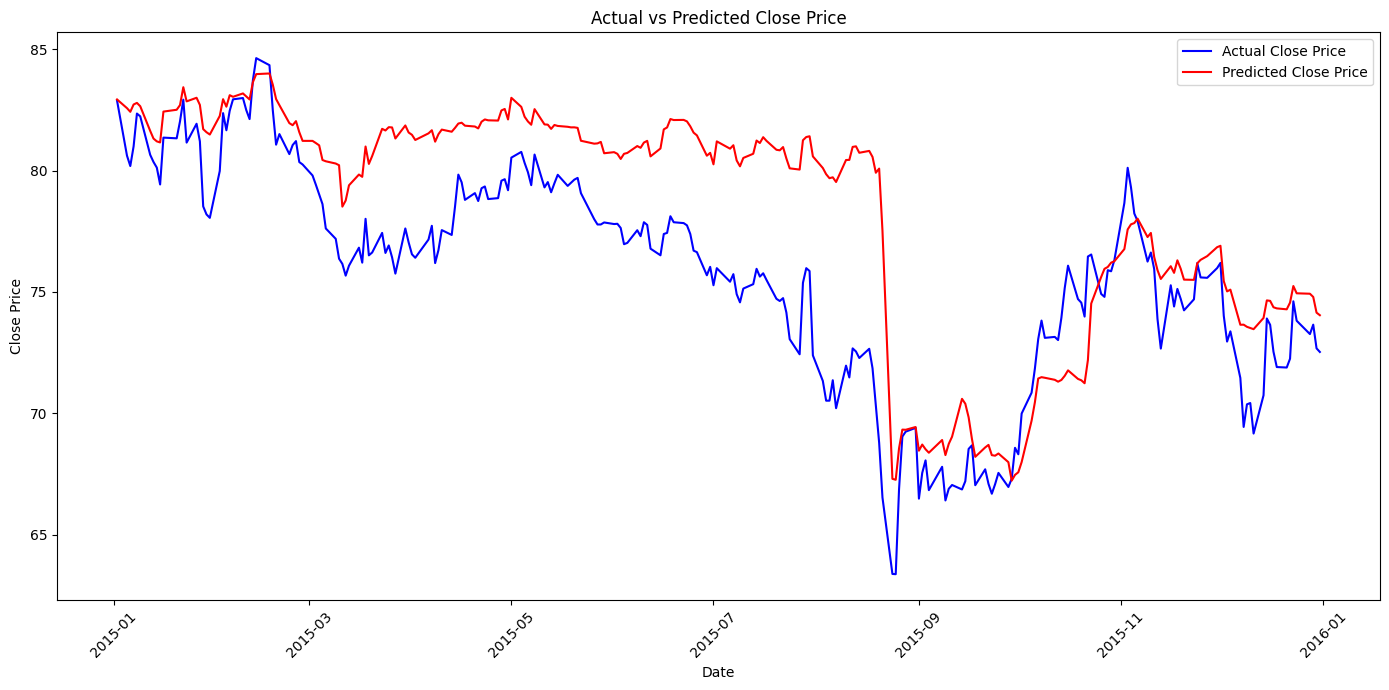

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# CSVファイルを読み込む
file_path = './xom.us.csv'  # ファイルパスを適切に設定する
data = pd.read_csv(file_path)

# 日付をdatetime型に変換する
data['Date'] = pd.to_datetime(data['Date'])

# Simple Moving Averages (SMA)
data['SMA25'] = data['Close'].rolling(window=25).mean()
data['SMA75'] = data['Close'].rolling(window=75).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# MACD
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# RSI
def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

data['RSI'] = calculate_rsi(data, 14)

# ストキャスティクス (Stochastic Oscillator)
def calculate_stochastic_oscillator(data, k_window, d_window):
    low_min = data['Low'].rolling(window=k_window).min()
    high_max = data['High'].rolling(window=k_window).max()

    data['%K'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    data['%D'] = data['%K'].rolling(window=d_window).mean()

    return data

data = calculate_stochastic_oscillator(data, 14, 3)

# ボリンジャーバンドの計算
window_size = 20
rolling_mean = data['Close'].rolling(window=window_size).mean()
rolling_std = data['Close'].rolling(window=window_size).std()

# ボリンジャーバンドの上限と下限を計算する
data['UpperBand'] = rolling_mean + 2 * rolling_std
data['LowerBand'] = rolling_mean - 2 * rolling_std

# データの準備
features = data[['Date', 'SMA25', 'SMA75', 'SMA200', 'MACD', 'Signal', 'RSI', '%K', '%D', 'UpperBand', 'LowerBand']].dropna()
target = data[['Date', 'Close']].shift(-1).dropna()  # 翌日の株価を予測

# 日付に基づいてデータを分割
train_features = features[(features['Date'] >= '2010-01-01') & (features['Date'] <= '2014-12-31')].set_index('Date')
train_target = target[(target['Date'] >= '2010-01-01') & (target['Date'] <= '2014-12-31')].set_index('Date')['Close']
test_features = features[(features['Date'] >= '2015-01-01') & (features['Date'] <= '2015-12-31')].set_index('Date')
test_target = target[(target['Date'] >= '2015-01-01') & (target['Date'] <= '2015-12-31')].set_index('Date')['Close']

# ランダムフォレスト回帰モデルを構築
model = RandomForestRegressor(n_estimators=100, random_state=42)

# モデルをトレーニング
model.fit(train_features, train_target)

# 予測を行う
y_pred = model.predict(test_features)

# モデルの評価
mse = mean_squared_error(test_target, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 特徴量の重要度を表示
feature_importances = model.feature_importances_
features_list = train_features.columns
importance_df = pd.DataFrame({'Feature': features_list, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
print(importance_df)

# 実際の値と予測値をプロット
plt.figure(figsize=(14, 7))
plt.plot(test_target.index, test_target, label='Actual Close Price', color='b')
plt.plot(test_target.index, y_pred, label='Predicted Close Price', color='r')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
